# Building Isolation tree in Python

In [1]:
import pandas as pd
import numpy as np
import random as rd

#### Defining base Functions

In [2]:
def iTree(df, l, e = 0):
    """Recursivley builds an iTree from a pandas data frame
    df = the data
    e = current depth
    l = max depth"""
    if df.shape[0] <= 1 or e >= l:
        return {'NodeType' : 'External',
               'Left' : None,
               'Right' :  None,
               'SplitAtt' : None,
               'SplitVal' : None,
               'Size' : df.shape[0],
               'Depth' : e}
    else:
        q = rd.choice(df.columns.values)
        p = np.random.uniform(low = df[q].min(), high = df[q].max())
        return {'NodeType': 'Internal',
               'Left' : iTree(df[df[q] < p], l, e + 1),
               'Right' : iTree(df[df[q] >= p], l, e + 1), 
               'SplitAtt' : q,
               'SplitVal' : p,
               'Size': df.shape[0],
                'Depth' : e
               }
    
def USS(n):
    """average path length of unsuccessful search in BST"""
    if n < 2:
        return 0
    elif n == 2:
        return 1
    else:
        return (2.0 * (np.log(n - 1.0) + 0.5772156649) + 2.0 * (n - 1.0)/n)

def PathLength(pnt, Tree, e = 0):
    """ Get Path length of a data point (pnt) from a tree (Tree) """
    if Tree['NodeType'] == 'External':
        return e + USS(Tree['Size']) 
    
    else:
        q = Tree['SplitAtt']
        p = Tree['SplitVal']
        if pnt[q] < p:
            return PathLength(pnt, Tree['Left'], e + 1)
        else:
            return PathLength(pnt, Tree['Right'], e + 1)
        
        
def iForest(df, nt , phi):
    """df - the data set, nt - the number of trees to build, phi - subsample size"""
    Forest = [None] * nt
    depth = np.ceil(np.log(phi))
    for i in xrange(nt):
        sub_sample = rd.sample(df.index, phi)
        Tree = iTree(df.iloc[sub_sample,:], l = depth)
        Forest[i] = Tree
    return Forest

def predict_iForest(df, Forest, Phi):
    """Takes an iForest and then predicts the values of each point, and then converts it into an anomoly score"""
    PL = pd.Series(0, index = range(len(df)))
    for i in range(len(Forest)):
        Tree = Forest[i]
        PL = PL + df.apply(lambda x: PathLength(x, Tree) , axis = 1)
    PL = PL/len(Forest)
    PL = np.power(2, -1 * PL/USS(Phi))
    return PL    
    
def Print_iTree(Tree, Direction = None):
    "pretty prints an iTree"
    #getting number of indents
    Prnt_str = ' ' * Tree['Depth'] + 'Depth: ' + str(Tree['Depth'])
    if Direction != None:
        Prnt_str = Prnt_str + ' (' + Direction + ')'
    if Tree['NodeType'] == 'External':
        Prnt_str = Prnt_str + ' - External Node - (' + str(Tree['Size']) + ')'
        print(Prnt_str)
    else:
        Prnt_str = Prnt_str + ' - Split Var: ' +  str(Tree['SplitAtt']) + ' at ' + str(round(Tree['SplitVal'],4))
        Prnt_str = Prnt_str + ' True: ' + str(round(Tree['Left']['Size']/(Tree['Size'] * 1.000),2) * 100) + '%'
        Prnt_str = Prnt_str + ' (' + str(Tree['Size']) + ')'
        print(Prnt_str)
        Print_iTree(Tree['Left'], 'Left')
        Print_iTree(Tree['Right'], 'Right')
   

### Building sample data set

Building a sample data set that have five variables and 20,000 rows

In [3]:
df =  pd.DataFrame(np.random.normal(0,1,100000).reshape(20000,5))

Going to make roughly 5% of the vairables outliers

In [4]:
df.iloc[1:1000, : ] = df.iloc[1:1000, : ] * 100

In [6]:
df.head(10)

,0,1,2,3,4
0,-1.360039,0.754741,0.735916,1.188438,-0.089023
1,156.425045,-184.315950,203.968584,-24.917730,104.560258
2,148.330996,114.054248,-18.369667,-107.845860,17.273466
3,-33.048664,33.278607,60.149266,36.048176,-84.744522
4,-16.110393,-80.782009,-81.301580,-14.556017,32.897648
5,-14.130154,-47.208320,-78.622111,51.259655,-44.270117
6,-90.536773,29.903436,-87.579522,18.887955,-119.215715
7,-93.688742,40.211375,-50.464986,-43.446238,-122.772799
8,172.132387,137.980752,81.130762,-16.978475,-131.120131
9,103.510952,142.973895,17.129006,-76.875710,27.776713


### Testing an iTree

Taking the above data and will build an iTree and see how the prediciton changes over itterations

In [8]:
Tree = iTree(df, np.ceil(np.log(256)))
Pred_PathLength = PathLength(df.iloc[5,], Tree)
Pred_PathLength

19.354274084830074

Now running it over 100 itterations


In [9]:
PL_outlier = pd.Series(np.zeros(100))
PL_normal = pd.Series(np.zeros(100))

In [10]:
for i in range(100):
    sub_sample = rd.sample(df.index, 256)
    Tree = iTree(df.iloc[sub_sample,:], np.ceil(np.log(256)))
    
    PL_outlier[i] = PathLength(df.iloc[1,], Tree)
    PL_normal[i] = PathLength(df.iloc[3000,], Tree)

How is the distribution of a normal point look

In [11]:
PL_normal.describe()

count    100.000000
mean      19.629698
std        1.323049
min       13.348880
25%       19.911980
50%       20.107410
75%       20.140605
max       20.173257
dtype: float64

Here is the distribution of an outlier point

In [12]:
PL_outlier.describe()

count    100.000000
mean       4.088382
std        3.272351
min        1.000000
25%        2.000000
50%        4.000000
75%        5.000000
max       20.165143
dtype: float64

So how does the subsample size change the predictions power. I'm going to run 100 forest per following sample size: {2,4,8,16,32,64,128,256,512,1024}

In [13]:
PL_outlier = pd.DataFrame(np.zeros(100 * 10).reshape(100,10))
PL_normal = pd.DataFrame(np.zeros(100 * 10).reshape(100,10))

Sample_Range = [2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]

PL_outlier.columns = Sample_Range
PL_normal.columns = Sample_Range

for i in range(10):
    for j in range(100):
        sub_sample = rd.sample(df.index, Sample_Range[i])
        Tree = iTree(df.iloc[sub_sample,:], np.ceil(np.log(Sample_Range[i])))
    
        PL_outlier.iloc[j,i] = PathLength(df.iloc[1,], Tree) 
        PL_normal.iloc[j,i] = PathLength(df.iloc[3000,], Tree)

The impact on normal points

In [14]:
PL_normal.mean(axis = 0)

2        1.000000
4        2.150000
8        4.518120
16       7.732620
32      11.034379
64      13.964232
128     16.738444
256     19.700127
512     22.308342
1024    23.839921
dtype: float64

The impact on an outlier

In [15]:
PL_outlier.mean(axis = 0)

2       1.000000
4       1.820000
8       2.797050
16      3.870305
32      3.730424
64      3.309365
128     3.480559
256     3.904751
512     5.046611
1024    5.810199
dtype: float64

### Testing an iForest

Now I'm going to build an iForest on the data and then test it's accuracy 

In [16]:
Sample_Size = 256
Forest = iForest(df, 100, Sample_Size)

In [17]:
out_test = predict_iForest(df, Forest, Sample_Size)
out_test.describe()

count    20000.000000
mean         0.402698
std          0.077455
min          0.380600
25%          0.382422
50%          0.384028
75%          0.387194
max          0.854410
dtype: float64

How does an iForest work for normal points

In [18]:
out_test[1001:2000].describe()

count    999.000000
mean       0.385214
std        0.004213
min        0.380672
25%        0.382411
50%        0.383855
75%        0.386604
max        0.418503
dtype: float64

And for outlier points

In [19]:
out_test[1:1000].describe()

count    999.000000
mean       0.736036
std        0.052956
min        0.501200
25%        0.703580
50%        0.743262
75%        0.775547
max        0.854410
dtype: float64

There exists a clear seperation among these group!  You can see the slightl bump in the density plot

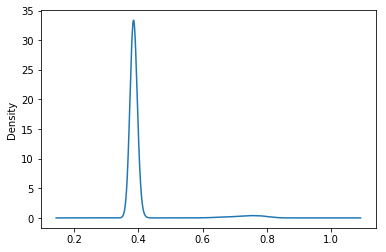

In [21]:
out_test.plot.kde()

### iForest on Wide data

I'm going to repeat the above test, but I'm going to make the data 500 variables wide. However, only certian variables will be choosen for outliers

In [22]:
df =  pd.DataFrame(np.random.normal(0,1,1000000).reshape(2000,500))
df.iloc[1:100, 1:40 ] = df.iloc[1:100, 1:40 ] * 100

In [23]:
Sample_Size = 256
Forest = iForest(df, 500, Sample_Size)

In [24]:
out_test = predict_iForest(df, Forest, Sample_Size)
out_test.describe()

count    2000.000000
mean        0.468327
std         0.008221
min         0.449048
25%         0.463509
50%         0.467026
75%         0.470848
max         0.510375
dtype: float64

How well it works on normal points

In [25]:
out_test[100:2000].describe()

count    1900.000000
mean        0.466900
std         0.005289
min         0.449048
25%         0.463330
50%         0.466638
75%         0.470204
max         0.483714
dtype: float64

And for the outlier points

In [26]:
out_test[1:100].describe()

count    99.000000
mean      0.495675
std       0.006443
min       0.480442
25%       0.491377
50%       0.495773
75%       0.500868
max       0.510375
dtype: float64

Intresting, there is a very slightly overlap between the Max of score and the min score of an outlier. However, How would we know that, as the total spread is roughly 0.06 points. :/

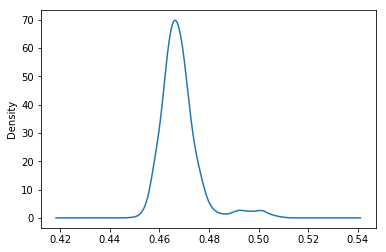

In [27]:
out_test.plot.kde()